In [14]:
from scipy.io import savemat
import argparse
import pickle
import os
import torch
import cmath 
import scipy.special
import os
import torch.nn as nn
from matplotlib.patches import Ellipse
import shutil
import math
from datetime import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import lightning as L
import wandb
from lightning.pytorch.loggers import WandbLogger
import time
import matplotlib.colors as mcolors

In [15]:
torch.set_default_dtype(torch.float64)

In [16]:
length_scale = 1
l = 1
g = 9.8
m = 1
damp_coeff = 0.5 
nat_freq = np.sqrt(g/l)
damp_ratio = damp_coeff/(2*m*nat_freq) 
cmap = plt.cm.Blues
cmap = cmap(np.linspace(0, 1, cmap.N))
cmap[:1, -1] = 0  
transparent_cmap = mcolors.ListedColormap(cmap)

In [17]:
nat_freq

3.1304951684997055

In [18]:
damp_ratio

0.07985957062499249

In [234]:
epochs = 6000
embed_dim = 500
latent_dim = 2
val_check = 100
batch_size = 32

In [54]:
def truncated_normal(t, mean=0.0, std=0.01):
    torch.nn.init.normal_(t, mean=mean, std=std)
    while True:
        cond = torch.logical_or(t < mean - 2*std, t > mean + 2*std)
        if not torch.sum(cond):
            break
        t = torch.where(cond, torch.nn.init.normal_(torch.ones(t.shape), mean=mean, std=std), t)
    return t

In [55]:
class Faddeeva(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z):
        z_np = z.detach().cpu().numpy()
        w_np = np.array(scipy.special.wofz(z_np), dtype=z_np.dtype)
        w = torch.from_numpy(w_np).to(z.device, dtype=z.dtype)
        ctx.save_for_backward(z, w)
        return w

    @staticmethod
    def backward(ctx, grad_output):
        z, w = ctx.saved_tensors
        pi_tensor = torch.tensor(torch.pi, device=z.device).double()
        two_i = torch.complex(
            torch.tensor(0.0, device=z.device).double(),
            torch.tensor(2.0, device=z.device).double()
        )
        sqrt_pi = torch.sqrt(pi_tensor)
        dw_dz = (two_i / sqrt_pi) - 2 * z * w
        gradient = dw_dz.conj() * grad_output
        
        return gradient

In [56]:
wofz = Faddeeva.apply

In [57]:
# # squared exponential kernel
# def kernel_ode(x1, x2, length_scale, nat_freq=None, damp_ratio=None):
#     length_scale = torch.tensor(length_scale, dtype=x1.dtype, device=x1.device)
    
#     diff = x1.unsqueeze(-1) - x2.unsqueeze(-2)
    
#     cov_matrix = torch.exp(-0.5 * (diff / length_scale)**2)
    
#     return cov_matrix

In [58]:
def kernel_ode(X,Y,l=1,freq=0.6,damping=0.05):
    def hfcn(l,gamma_q,gamma_p,t,tp):
        out=(gfcn(l,gamma_q,tp,t)-torch.exp(-gamma_p*t)*gfcn(l,gamma_q,tp,0))/(gamma_q+gamma_p)
        return out

    def gfcn(l,gamma_q,t,tp):
        out=2*torch.exp(l**2*gamma_q**2/4)*torch.exp(-gamma_q*(t-tp))-torch.exp(-(t-tp)**2/l**2)*wofz(1j*zfcn(l,t,tp,gamma_q))-torch.exp(-tp**2/l**2)*torch.exp(-gamma_q*t)*wofz(-1j*zfcn(l,0,tp,gamma_q))
        return out

    def zfcn(l,t,tp,gamma_q):
        out=(t-tp)/l-(l*gamma_q)/2
        return out
    
    device = X.device
    l = torch.tensor(l, device=device).double()
    # freq = torch.tensor(freq, device=device).double()
    # damping = torch.tensor(damping, device=device).double()

    d_ode=freq**2 
    c_ode=2*damping*freq
    alpha=c_ode/2
    w=torch.sqrt(4*d_ode-c_ode**2)/2
    
    length_X=X.numel()
    length_Y=Y.numel()

    t = X.double().unsqueeze(-1).expand(*X.shape[:-1], X.shape[-1], Y.shape[-1])
    tp = Y.double().unsqueeze(-2).expand(*Y.shape[:-1], X.shape[-1], Y.shape[-1])
    gamma=alpha+1j*w
    gamma_t=alpha-1j*w

    Sigma = (torch.sqrt(torch.pi*l**2)/8/w**2*(
        hfcn(l,gamma_t,gamma,t,tp) \
        + hfcn(l,gamma,gamma_t,tp,t) \
        + hfcn(l,gamma,gamma_t,t,tp) \
        + hfcn(l,gamma_t,gamma,tp,t) \
        - hfcn(l,gamma_t,gamma_t,t,tp) \
        - hfcn(l,gamma_t,gamma_t,tp,t) \
        - hfcn(l,gamma,gamma,t,tp) \
        - hfcn(l,gamma,gamma,tp,t)
    )).real

    return Sigma

In [59]:
def gaussian_process(train_time_points, prior_mean, prior_var, test_time_points, length_scale, nat_freq=None, damp_ratio=None):
    device = train_time_points.device
    num_batches, train_time = train_time_points.shape
    _, test_time = test_time_points.shape
    
    # compute covariance matrix for training points
    cov_batches = kernel_ode(train_time_points, train_time_points, length_scale, nat_freq, damp_ratio).to(device)

    cov_batches += torch.eye(cov_batches.size(-1), device=device).unsqueeze(0) * 1e-4

    cholesky = torch.linalg.cholesky(cov_batches + torch.diag_embed(prior_var))

    # gp likelihood calculation
    likelihood_constant = train_time * torch.log(torch.tensor([2*torch.pi], device=device))
    likelihood_log_determinant = 2 * torch.sum(torch.log(torch.diagonal(cholesky, dim1=-2, dim2=-1)), 1)

    # prior_mean: (batch_size, train_time)
    prior_mean_reshaped = prior_mean.unsqueeze(-1)  # (batch_size, train_time, 1)
    inverse_cov_mean = torch.cholesky_solve(prior_mean_reshaped, cholesky)  # (batch_size, train_time, 1)
    prior_mean_trans = prior_mean_reshaped.transpose(-1, -2)  # (batch_size, 1, train_time)
    likelihood_quadratic = torch.matmul(prior_mean_trans, inverse_cov_mean).view(num_batches)

    gp_likelihood = -0.5 * (likelihood_constant + likelihood_quadratic + likelihood_log_determinant)

    if torch.equal(train_time_points, test_time_points):
        inverse_cov_cov = torch.cholesky_solve(cov_batches, cholesky)
        diag_cov = torch.diag_embed(torch.diagonal(cov_batches, dim1=-2, dim2=-1))
        gp_var = torch.sum(diag_cov - cov_batches * inverse_cov_cov, 1)
        gp_mean = torch.matmul(cov_batches.transpose(1, 2), inverse_cov_mean).squeeze(-1)
        gp_var = gp_var + 1e-6
        return gp_mean, gp_var, gp_likelihood
    else:
        cov_star = kernel_ode(train_time_points, test_time_points, length_scale, nat_freq, damp_ratio).to(device)      # (num_batches, train_time, test_time)
        cov_star_star = kernel_ode(test_time_points, test_time_points, length_scale, nat_freq, damp_ratio).to(device) # (num_batches, test_time, test_time)
        inverse_cov_cov_star = torch.cholesky_solve(cov_star, cholesky)    # (num_batches, train_time, test_time)
        gp_mean = torch.matmul(cov_star.transpose(1, 2), inverse_cov_mean).squeeze(-1) # (num_batches, test_time)
        gp_var_full = cov_star_star - torch.matmul(cov_star.transpose(1, 2), inverse_cov_cov_star)
        gp_var = torch.diagonal(gp_var_full, dim1=1, dim2=2) + 1e-4
        return gp_mean, gp_var, gp_likelihood

In [60]:
def training_transform(frame, trajectories):
    # train with 60/40 split
    train_time = int(0.6 * len(trajectories))
    return frame[:train_time], trajectories[:train_time]

In [61]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, path, transform=None):
        super().__init__()

        with open(path, "rb") as f:
            data = pickle.load(f)
            self.dt = data["dt"]
            self.trajectories, self.frames = data["dataset"]
            
        _, _, self.py, self.px = self.frames.shape
        self.transform = transform

    def __getitem__(self, index):
        frames = torch.tensor(self.frames[index]).double()
        trajectories = torch.tensor(self.trajectories[index]).double()
        if self.transform is not None: 
            frames, trajectories = self.transform(frames, trajectories)
        return frames, trajectories

    def __len__(self):
        return self.trajectories.shape[0]

In [62]:
# create training and testing datasets
train_dataset = Dataset("../Data/Dataset.pkl", training_transform)
test_dataset = Dataset("../Data/Dataset.pkl")

# create training and testing loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=5)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=5)

In [63]:
class Encoder(torch.nn.Module):
    def __init__(self, px, py, embed_dim, latent_dim):
        super(Encoder, self).__init__()
        self.px = px
        self.py = py
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(self.px*self.py, self.embed_dim),
            nn.Tanh(),
            nn.Linear(self.embed_dim, self.latent_dim)
        )

    # initialize weights with values drawn from truncated normal distribution
    def initialize_weights(self, m):
        if isinstance(m, nn.Linear):
            m.weight.data = truncated_normal(m.weight.data, std=1.0 / math.sqrt(float(m.in_features))+0.0000001)
            nn.init.constant_(m.bias.data, 0)

    def forward(self, x):
        batch_size = x.shape[0]
        params = self.encoder(x.double().flatten(2)) 
        # reshape params: (batch, frames, 2)
        params = params.view(batch_size, -1, 2)
        mean = params[:, :, 0:1]
        var = torch.exp(params[:, :, 1:])
        return mean, var

In [64]:
class Decoder(torch.nn.Module):
    def __init__(self, px, py, embed_dim, latent_dim):
        super(Decoder, self).__init__()
        self.px = px
        self.py = py
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim

        self.decoder = nn.Sequential(
            nn.Linear(1, self.embed_dim),
            nn.Tanh(),
            nn.Linear(self.embed_dim, self.px*self.py)
        )

    # initialize weights with values drawn from truncated normal distribution
    def initialize_weights(self, m):
        if isinstance(m, nn.Linear):
            m.weight.data = truncated_normal(m.weight.data, std=1.0 / math.sqrt(float(m.in_features))) #CHANGE +0.0000001
            nn.init.constant_(m.bias.data, 0)

    def forward(self, x):
        batch_size = x.shape[0]
        reconstructed = self.decoder(x)
        reconstructed = reconstructed.view(batch_size, -1, self.py, self.px)
        return reconstructed

In [65]:
def gauss_cross_entropy(mu1, var1, mu2, var2):
    term0 = 1.8378770664093453 # log(2*pi)
    term1 = torch.log(torch.abs(var2)) #CHANGE 0.001
    term2 = (var1 + mu1**2 - 2 * mu1 * mu2 + mu2**2) / (torch.abs(var2)) #CHANGE 0.001

    cross_entropy = -0.5*(term0 + term1 + term2)

    return cross_entropy

In [66]:
def mse_scale(a, b):
    return (torch.sum(b*a))/torch.sum(b**2)

In [226]:
def heatmap(frames, time):
    video = np.array([(t+4)*v for t,v in enumerate(frames)]) 
    return np.max(video, 0)*(1/(4+time))

In [227]:
def plot(true_frames, true_trajectories, reconstructed_frames, scale, mean, var, axes):
    num_frames = true_frames.shape[1]
    time = int(num_frames * train_dataset.dt)
    for i, ax in enumerate(axes[0]):
        image = heatmap(true_frames[i,:,:,:], num_frames)
        ax.imshow(image, cmap=transparent_cmap, extent=[0, image.shape[1], 0, image.shape[0]])
    
    for i, ax in enumerate(axes[2]):
        ax.plot(np.linspace(0, time, len(true_trajectories[i])), true_trajectories[i])        

    for i, ax in enumerate(axes[1]):
        image = heatmap(reconstructed_frames[i,:,:,:], num_frames)
        ax.imshow(image, cmap=transparent_cmap, extent=[0, image.shape[1], 0, image.shape[0]])

    for i, ax in enumerate(axes[3]):
        mean_i = scale*mean[i].squeeze().cpu()
        std_i = scale*np.sqrt(var[i].squeeze().cpu())

        x = np.linspace(0, time, len(mean_i))
        ax.plot(x, mean_i)
        ax.fill_between(x, mean_i + 2*std_i, mean_i - 2*std_i, alpha=0.5)
    
    return axes

In [228]:
class Plotting(L.pytorch.callbacks.Callback):
    def __init__(self):
        super().__init__() 
        self.frequency_per_epoch = []
        self.damping_per_epoch = []
        self.current_epoch_freq = []
        self.current_epoch_damping = []
    
    def on_validation_batch_end(self, trainer: L.Trainer, model, outputs, batch, batch_idx):        
        loss, (gp_mean, gp_var, latent_samples, reconstructed_video, frequency, damping) = outputs
        # loss, (gp_mean, gp_var, latent_samples, reconstructed_video) = outputs

        reconstructed_video = (reconstructed_video > 0.5).int()
        frames, trajectories = batch
        frames = frames.cpu()
        trajectories = trajectories.cpu() 
        batch_size, time, px, py = frames.shape

        scale = mse_scale(trajectories, gp_mean.cpu())
        scaled_latent_samples = latent_samples
        scaled_var = gp_var
        scaled_mean = gp_mean
        
        num_cols = batch_size if batch_size < 4 else 4 
        fig, axes = plt.subplots(4, num_cols, figsize=(10,8))    

        print("Frequency", frequency, "\nDamping", damping)
        
        plot(frames, trajectories, reconstructed_video.cpu().numpy(), scale, scaled_mean, scaled_var, axes=axes)
        fig.suptitle(str(trainer.current_epoch)+' ELBO: ' + str(-loss.item()))
        # trainer.logger.experiment.log({"reconstruction": wandb.Image(fig)}) 
        plt.show()

        # Collect frequency and damping for the current batch
        self.current_epoch_freq.append(frequency.item())
        self.current_epoch_damping.append(damping.item())

    def on_validation_epoch_end(self, trainer, pl_module):
        avg_freq = np.mean(self.current_epoch_freq)
        avg_damp = np.mean(self.current_epoch_damping)
        self.frequency_per_epoch.append(avg_freq)
        self.damping_per_epoch.append(avg_damp)

        epochs = np.arange(1, len(self.frequency_per_epoch) + 1)
        fig, (ax_freq, ax_damp) = plt.subplots(nrows=1,ncols=2,figsize=(10, 3),constrained_layout=True)

        ax_freq.plot(epochs,self.frequency_per_epoch, marker='o',markersize=4,linewidth=1,color='tab:blue',label='Frequency')
        ax_freq.set_xlabel('Epoch', fontsize=10)
        ax_freq.set_ylabel('Frequency', color='tab:blue', fontsize=10)
        ax_freq.tick_params(axis='y', labelcolor='tab:blue')
        ax_freq.set_title('Frequency Over Epochs', fontsize=12)
        ax_freq.grid(True, linewidth=0.5)
        ax_freq.legend(loc='upper left', fontsize=8)

        ax_damp.plot(epochs,self.damping_per_epoch,marker='x',markersize=4, linewidth=1, color='tab:red', label='Damping')
        ax_damp.set_xlabel('Epoch', fontsize=10)
        ax_damp.set_ylabel('Damping', color='tab:red', fontsize=10)
        ax_damp.tick_params(axis='y', labelcolor='tab:red')
        ax_damp.set_title('Damping Over Epochs', fontsize=12)
        ax_damp.grid(True, linewidth=0.5)
        ax_damp.legend(loc='upper left', fontsize=8)

        plt.show()
        plt.close(fig) 
        self.current_epoch_freq = []
        self.current_epoch_damping = []   

In [229]:
class Model(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

        self.Dq = nn.Parameter((torch.tensor(0.0, dtype=torch.double)))
        self.Cq = nn.Parameter((torch.tensor(0.0, dtype=torch.double)))

    def _step(self, mode, batch):
        Dq =  nn.functional.softplus(self.Dq) # constrain to be > 0 
        Cq = nn.functional.softplus(self.Cq) # constrain to be > 0

        frequency = torch.sqrt(Dq)
        damping = Cq/(2*frequency)
        
        frame, trajectory = batch
        batch_size, time, px, py = frame.shape

        device = frame.device
        vae_mean, vae_var = self.encoder(frame.double())

        # create time for gp
        time_points = torch.arange(time, device=device) * train_dataset.dt
        batches_time = torch.cat([time_points.view(1, time) for i in range(batch_size)], 0)     
        
        # compute posterior mean and variance with the gaussian process
        # gp_mean, gp_var, gp_likelihood = gaussian_process(batches_time, vae_mean[:,:,0], vae_var[:,:,0], batches_time, length_scale, nat_freq, damp_ratio)
        gp_mean, gp_var, gp_likelihood = gaussian_process(batches_time, vae_mean[:,:,0], vae_var[:,:,0], batches_time, length_scale, frequency, damping)

        gp_mean = torch.unsqueeze(gp_mean, 2)
        gp_var = torch.unsqueeze(gp_var, 2)
        
        # compute loss function of vae
        # compute cross entropy between encoder and gp distribution predictions
        cross_entropy = torch.sum(gauss_cross_entropy(gp_mean, gp_var, vae_mean, vae_var), (1,2))
        # compute KL divergence bewteen prior distribution of gp and predicted distribution of vae
        kld = torch.mean(gp_likelihood - cross_entropy)
        
        # compute reconstruction loss terms    
        epsilon = torch.randn((batch_size, time, 1), device=device)
        latent_samples = gp_mean + epsilon * torch.sqrt(gp_var)
        reconstructed_video_logits = self.decoder(latent_samples)
        reconstructed_video = torch.sigmoid(reconstructed_video_logits)
        reconstruction_loss = (nn.BCEWithLogitsLoss(reduction='sum')(reconstructed_video_logits, frame)) / batch_size
        
        #compute total loss
        loss = reconstruction_loss - 50.*kld
        
        # log loss
        self.log(f"{mode}/loss", loss, on_step=False, on_epoch=True, prog_bar=True)
    
        # return loss, (gp_mean, gp_var, latent_samples, reconstructed_video)

        return loss, (gp_mean, gp_var, latent_samples, reconstructed_video, frequency, damping)

    def training_step(self, batch):
        return self._step("training", batch)[0]

    def validation_step(self, batch):
        return self._step("validation", batch)

    def configure_optimizers(self):
        learning_rate = 1e-3
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        return optimizer

In [230]:
model = Model(
    Encoder(train_dataset.px, train_dataset.py, embed_dim, latent_dim),
    Decoder(train_dataset.px, train_dataset.py, embed_dim, latent_dim)
)

In [231]:
# run = wandb.init(project="PEGP-VAE", name=f"Physics_0_{int(time.time())}")
wandb_logger = None #WandbLogger()

In [232]:
trainer = L.Trainer(max_epochs=epochs, callbacks=[Plotting()], check_val_every_n_epoch=val_check, logger=wandb_logger)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type    | Params | Mode 
-------------------------------------------------
0 | encoder      | Encoder | 1.6 M  | train
1 | decoder      | Decoder | 1.6 M  | train
  | other params | n/a     | 2      | n/a  
-------------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.823    Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Frequency tensor(0.8326, device='cuda:0') 
Damping tensor(0.4163, device='cuda:0')


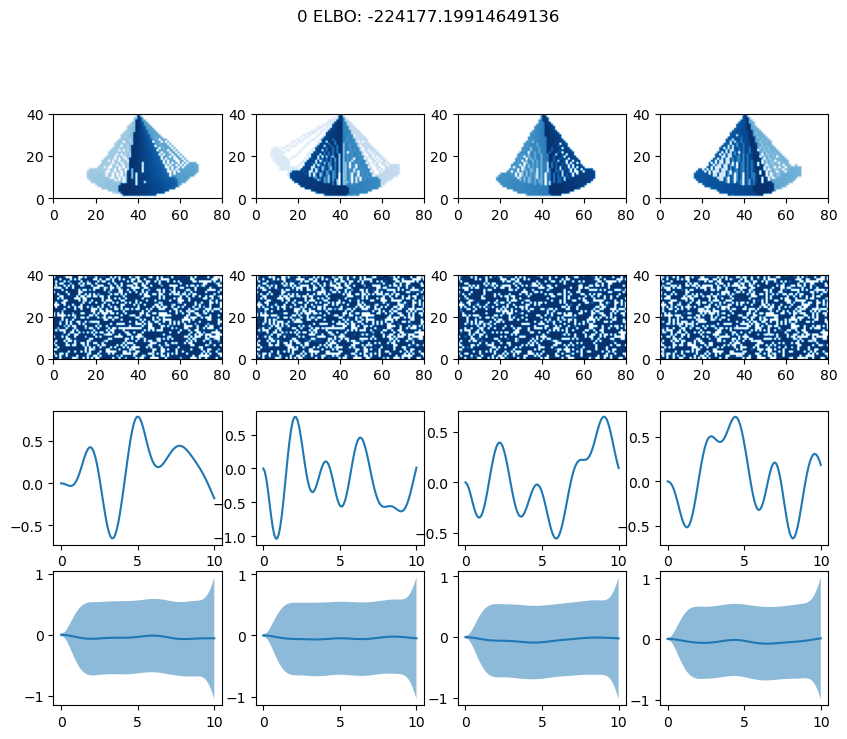

Frequency tensor(0.8326, device='cuda:0') 
Damping tensor(0.4163, device='cuda:0')


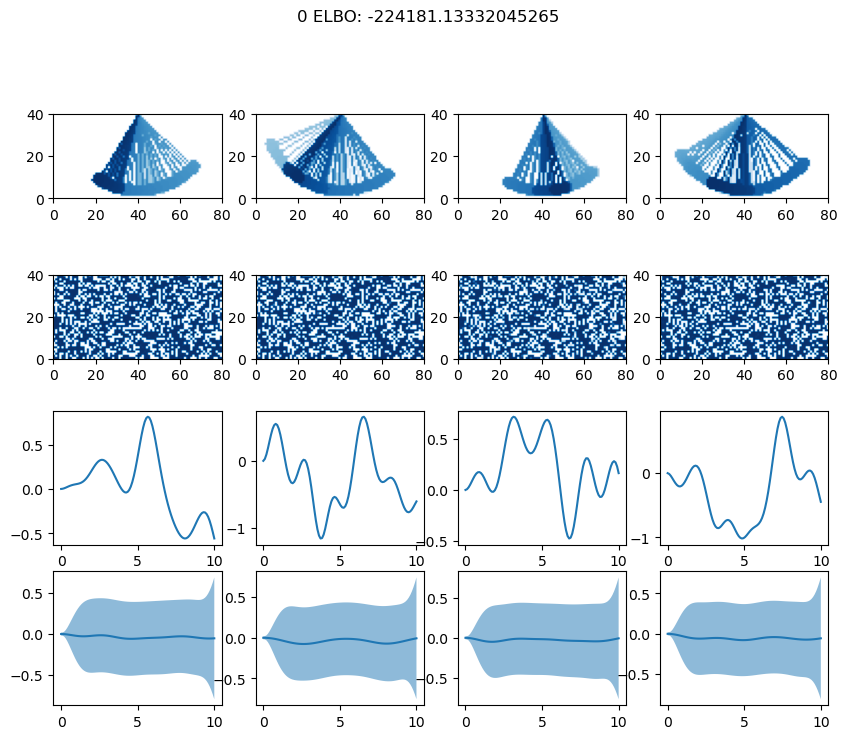

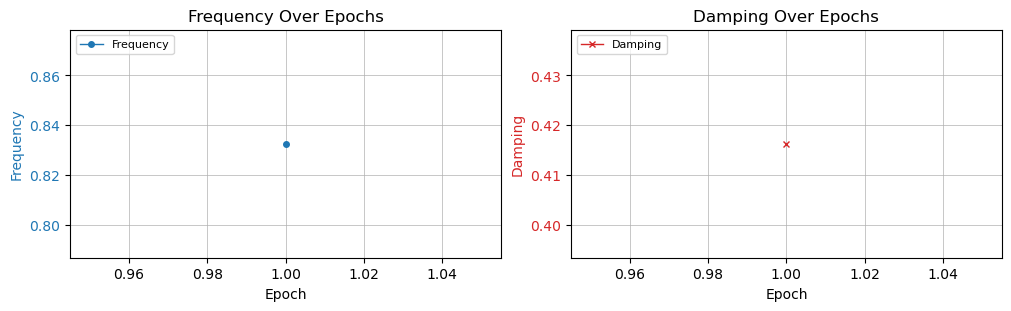

Training: |                                               | 0/? [00:00<?, ?it/s]

In [233]:
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)